A notebook to investigate the albedo dynamics at point scale.

In [3]:
import ee
import geemap
# from geemap import cartoee
# import cartopy.crs as ccrs
# import geemap.colormaps as cm
import matplotlib.pyplot as plt
# from geetools import batch
# import numpy as np
import pandas as pd
import seaborn as sns
# import time 

In [4]:
Map = geemap.Map()
Map 

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Prepare Harmonized Albedo

In [5]:
date_start = ee.Date.fromYMD(1984, 1, 1)
date_end = ee.Date.fromYMD(2020, 12, 31)


# yearnum = 2021
# monthnum = 9
# date_start = ee.Date.fromYMD(yearnum, monthnum, 1)
# date_end = ee.Date.fromYMD(yearnum, monthnum+1, 1)
# titlestr = "albedo " + str(yearnum) + "-0" + str(monthnum)

In [6]:
def addTotalAlbedo(image):
    albedo = image.expression(
        '1.0065 * Blue + 1.1902 * Green - 2.6738 * Red + 1.1700 * NIR + 0.9211 * SWIR1 - 1.1667 * SWIR2 + 0.1757',
        {
            'Blue': image.select('Blue'),
            'Green': image.select('Green'),
            'Red': image.select('Red'),
            'NIR': image.select('NIR'),
            'SWIR1': image.select('SWIR1'),
            'SWIR2': image.select('SWIR2')
        }
    ).rename('totalAlbedo')
    return image.addBands(albedo).copyProperties(image, ['system:time_start'])

def addVisnirAlbedo(image):
    albedo = image.expression(
        '0.7605 * Blue + 0.8090 * Green - 1.8376 * Red + 0.9145 * NIR + 0.1627',
        {
            'Blue': image.select('Blue'),
            'Green': image.select('Green'),
            'Red': image.select('Red'),
            'NIR': image.select('NIR')
        }
    ).rename('visnirAlbedo')
    return image.addBands(albedo).copyProperties(image, ['system:time_start'])


## If VIS-NIR bands albedo

In [7]:
''''if viz-nir bands albedo'''
rmaCoefficients = {
  'itcpsL7': ee.Image.constant([-0.0084, -0.0065, 0.0022, -0.0768]),
  'slopesL7': ee.Image.constant([1.1017, 1.0840, 1.0610, 1.2100]),
  'itcpsS2': ee.Image.constant([0.0210, 0.0167, 0.0155, -0.0693]),
  'slopesS2': ee.Image.constant([1.0849, 1.0590, 1.0759, 1.1583])
}; #rma
# Function to get and rename bands of interest from OLI.
def renameOli(img):
  return img.select(
    ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL', 'QA_RADSAT'], #'QA_PIXEL', 'QA_RADSAT'
    ['Blue',  'Green', 'Red',   'NIR',   'QA_PIXEL', 'QA_RADSAT']) #'QA_PIXEL', 'QA_RADSAT'

# Function to get and rename bands of interest from ETM+, TM.
def renameEtm(img):
  return img.select(
    ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'QA_PIXEL', 'QA_RADSAT'], #,   'QA_PIXEL', 'QA_RADSAT'
    ['Blue',  'Green', 'Red',   'NIR',   'QA_PIXEL', 'QA_RADSAT']) #, 'QA_PIXEL', 'QA_RADSAT'

# Function to get and rename bands of interest from Sentinel 2.
def renameS2(img):
  return img.select(
    ['B2',   'B3',    'B4',  'B8',  'QA60', 'SCL'],
    ['Blue', 'Green', 'Red', 'NIR', 'QA60', 'SCL']
  )

def oli2oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .toFloat()

def etm2oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .multiply(rmaCoefficients["slopesL7"]) \
    .add(rmaCoefficients["itcpsL7"]) \
    .toFloat()
    # .round() \
    # .toShort() 
    # .addBands(img.select('pixel_qa'))

def s22oli(img):
  return img.select(['Blue', 'Green', 'Red', 'NIR']) \
    .multiply(rmaCoefficients["slopesS2"]) \
    .add(rmaCoefficients["itcpsS2"]) \
    .toFloat()
    # .round() \
    # .toShort() # convert to Int16
    # .addBands(img.select('pixel_qa'))

def imRangeFilter(image):
  maskMax = image.lt(1)
  maskMin = image.gt(0)
  return image.updateMask(maskMax).updateMask(maskMin)

'''
Cloud mask for Landsat data based on fmask (QA_PIXEL) and saturation mask 
based on QA_RADSAT.
Cloud mask and saturation mask by sen2cor.
Codes provided by GEE official. '''

# the Landsat 8 Collection 2
def maskL8sr(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Cirrus
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  # opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  # thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  #image.addBands(opticalBands, {}, True) \ maybe not available in python api
  return image.select(['Blue', 'Green', 'Red', 'NIR']).multiply(0.0000275).add(-0.2) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

  
# the Landsat 4, 5, 7 Collection 2
def maskL457sr(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Unused
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  # opticalBands = image.select('SR_B.')
  # opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  # thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)

  # Replace the original bands with the scaled ones and apply the masks.
  return image.select(['Blue', 'Green', 'Red', 'NIR']).multiply(0.0000275).add(-0.2) \
      .updateMask(qaMask) \
      .updateMask(saturationMask)
 #
 # Function to mask clouds using the Sentinel-2 QA band
 # @param {ee.Image} image Sentinel-2 image
 # @return {ee.Image} cloud masked Sentinel-2 image
 #
def maskS2sr(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  # Bits 1 is saturated or defective pixel
  not_saturated = image.select('SCL').neq(1)
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0)) 

  return image.updateMask(mask).updateMask(not_saturated)


In [8]:
# Define function to prepare OLI images.
def prepOli(img):
  orig = img
  img = renameOli(img)
  img = maskL8sr(img)
  img = oli2oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()))

# Define function to prepare ETM+/TM images.
def prepEtm(img):
  orig = img
  img = renameEtm(img)
  img = maskL457sr(img)
  img = etm2oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()))

# Define function to prepare S2 images.
def prepS2(img):
  orig = img
  img = renameS2(img)
  img = maskS2sr(img)
  img = s22oli(img)
  # img = addTotalAlbedo(img)
  img = addVisnirAlbedo(img)
  return ee.Image(img.copyProperties(orig, orig.propertyNames()).set('SATELLITE', 'SENTINEL_2'))


# point cumsum anomaly

In [17]:
# poi = ee.Geometry.Point([-54.2955, 72.8932]) # UPE_L
# poi = ee.Geometry.Point([-48.8355, 67.0670]) # KAN_M
poi = ee.Geometry.Point([-49.5358, 64.4822]) # NUK_L

# create filter for image collection
colFilter = ee.Filter.And(
    ee.Filter.geometry(poi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    ee.Filter.calendarRange(7, 8, 'month'),
    # ee.Filter.lt('CLOUD_COVER', 50)
)

s2colFilter =  ee.Filter.And(
    ee.Filter.geometry(poi), # filterbounds not available on python api https://github.com/google/earthengine-api/issues/83
    ee.Filter.date(date_start, date_end),
    ee.Filter.calendarRange(7, 8, 'month'),
    ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)
)

oliCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepOli) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
etmCol = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tmCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
tm4Col = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2') \
            .filter(colFilter) \
            .map(prepEtm) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
s2Col = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filter(s2colFilter) \
            .map(prepS2) \
            .select(['visnirAlbedo']) # .select(['totalAlbedo']) or  .select(['viznirAlbedo'])
landsatCol = oliCol.merge(etmCol).merge(tmCol).merge(tm4Col)
multiSat = landsatCol.merge(s2Col).map(imRangeFilter).sort('system:time_start', True)
# get the average  
meanAlbedo = multiSat.filterDate('1984-01-01', '2004-12-31').mean()

In [18]:
# https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard by https://github.com/guiattard
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [19]:
# cumulative.size().getInfo()
point = multiSat.filterDate('2005-01-01', '2020-12-31').getRegion(poi, 90).getInfo()
pointmean = meanAlbedo.reduceRegion(ee.Reducer.mean(), poi,90).getInfo()

In [20]:
df = ee_array_to_df(point, ['viznirAlbedo'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

df = df.groupby(['year', 'month']).mean().reset_index()
df['day'] = 1

df['anomaly'] = df['viznirAlbedo'] - pointmean.get('viznirAlbedo')
df['albedo anomaly (cumsum)'] = df['anomaly'].cumsum()
df['time'] = pd.to_datetime(df[['year', 'month', 'day']])
df['station'] = 'NUK_L'
dfall = pd.DataFrame() # comment after 1st run
dfall = pd.concat([dfall, df])

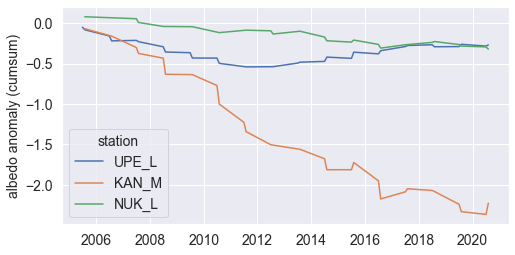

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_theme(style="darkgrid")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('legend', title_fontsize=MEDIUM_SIZE)
plt.rcParams["font.family"] = "Arial"
sns.lineplot(data=dfall.reset_index(), x='time', y='albedo anomaly (cumsum)', hue='station')
ax.set(xlabel="")
fig.savefig("print/albedoAnomalyPoi.pdf", dpi=300, bbox_inches="tight")

# pie chart of dark zone class

In [2]:
df = pd.read_excel(r"satellite spectra.xlsx", sheet_name="dark class")

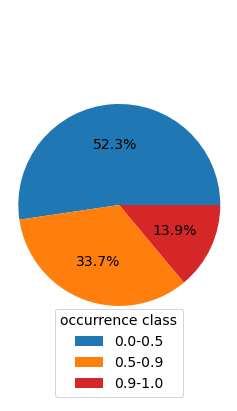

In [29]:

fig, ax = plt.subplots(figsize=(4,7.3))
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax.pie(df.area, labels = df.occurrence, labeldistance=None, colors=['#1f77b4', '#ff7f0e','#d62728'],autopct='%1.1f%%')
ax.axis('equal')
ax.legend(loc='lower center', title="occurrence class")
fig.savefig("print/qgis/pieDarkClass.png", dpi=300,bbox_inches="tight")